In [1]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

# Timeseries forecasting with ARIMA model

---

## Loading modules and reading the data

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:
RAW_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '02_processed'

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [5]:
sns.set_style('whitegrid')

In [6]:
def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
    if raw_path:
        path = str(RAW_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
    else:
        path = str(PROCESSED_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
        
    
    df = df.astype({col: 'float32' for col in ['Open', 'High', 'Low', 'Close', 'Adj Close',]})
    df['stock_name'] = df['stock_name'].astype('str')
    df['Volume'] = df['Volume'].astype('int32')

    df['Date'] = pd.to_datetime(df['Date'], format='ISO8601', utc='True')
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    return df

In [7]:
df = read_and_format_csv(subfolder_path='Information_Technology/AAPL.csv', raw_path=True)

In [8]:
df.sort_values(by='Date', inplace=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [9]:
df.dtypes

Date          datetime64[ns]
Adj Close            float32
Close                float32
High                 float32
Low                  float32
Open                 float32
Volume                 int32
stock_name            object
dtype: object

#### Notes about the dataset

<ul>
    <li>Daily resolution Apple stock Dataset</li>
    <li>The currency used is American dollar</li>
</ul>

In [10]:
df.shape

(11074, 8)

In [11]:
df.Date.max()

Timestamp('2024-11-14 00:00:00')

## Focusing on Daily resolution and returns

---

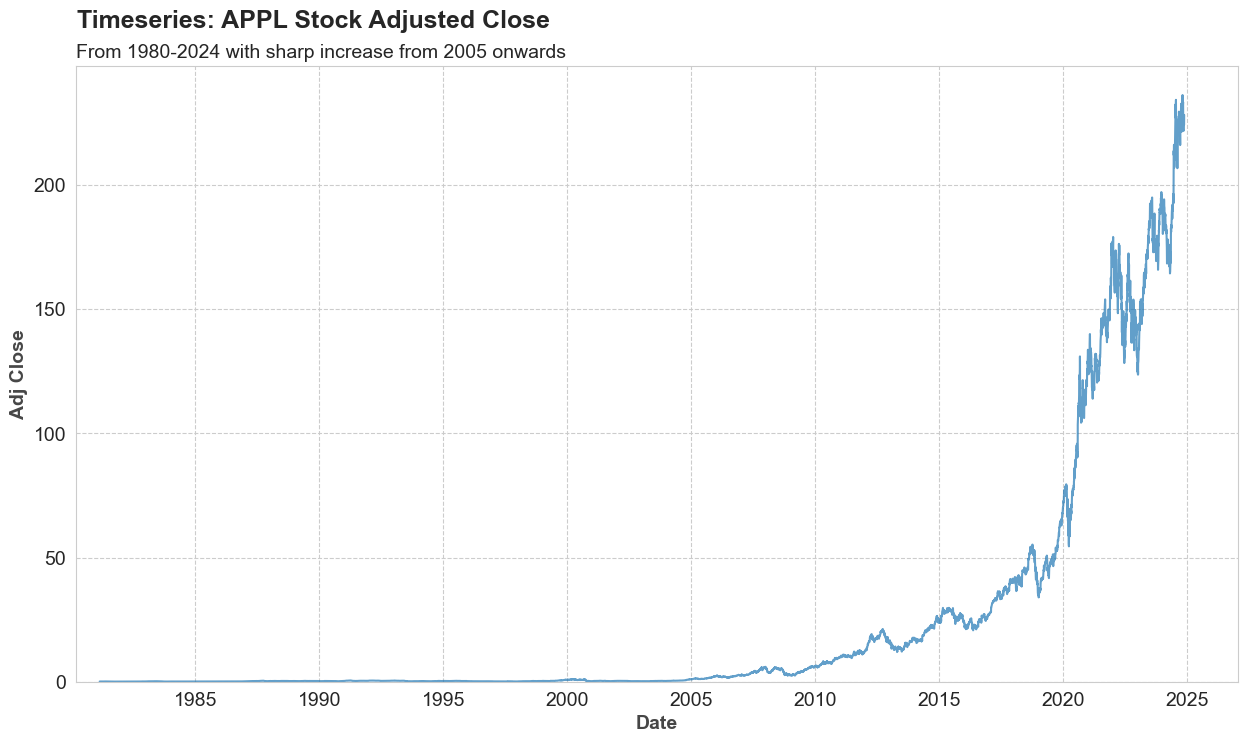

In [72]:
f, ax = plt.subplots(nrows=1, ncols=1,)

sns.lineplot(data=df, x='Date', y='Adj Close', markers='o', alpha=0.7)

ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.2835, 0.95
f.suptitle(t='Timeseries: APPL Stock Adjusted Close', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='From 1980-2024 with sharp increase from 2005 onwards', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
ax.set_ylim(0)
ax.grid(linestyle='--',)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

f.savefig('../outputs/figures/Timeseries_APPL.png', dpi=300)


We can see from this Timeseries that it has Trends but No clearn evidence of seasonality and is definitely not stationary so we need to transform it, I believe I should use first difference or normalised difference (pct change)

In [13]:
df['Returns'] = df['Adj Close'].pct_change()
df['first_diff'] = df['Adj Close'].diff()
df['cumilative_returns'] = (1 + df['Returns']).cumprod() - 1
df['20_day_sma'] = df['Adj Close'].rolling(window=20).mean()
df['50_day_sma'] = df['Adj Close'].rolling(window=50).mean()

df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,NaN,NaN,NaN,NaN,NaN
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,-0.052171,-0.005156,-0.052171,NaN,NaN


In [14]:
df = df.loc[df['Date'].dt.year > pd.Timestamp('1980').year].reset_index(drop=True)
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289,0.200004,NaN,NaN
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578,0.173918,NaN,NaN


In [15]:
df.iloc[:, 1:].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Adj Close,Close,High,Low,Open,Volume,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
count,11061.000000,11061.000000,11061.000000,11061.000000,11061.000000,1.106100e+04,11061.000000,11061.000000,11061.000000,11055.000000,11025.000000
mean,22.893742,23.732557,23.969788,23.473480,23.716425,3.025108e+08,0.001077,0.020622,230.636108,22.711770,22.462230
std,48.389771,48.864803,49.337830,48.341053,48.823261,3.215887e+08,0.027785,0.916040,489.601929,48.008574,47.419193
min,0.037815,0.049107,0.049665,0.049107,0.049665,-2.108338e+09,-0.518692,-10.566132,-0.617392,0.043122,0.044622
10%,0.103992,0.134487,0.137277,0.132813,0.135045,6.835660e+07,-0.028096,-0.176617,0.052179,0.105160,0.101707
25%,0.243658,0.300781,0.306429,0.292411,0.300223,1.110652e+08,-0.012620,-0.008989,1.465305,0.244635,0.251087
50%,0.442485,0.540179,0.549107,0.531250,0.540179,2.030448e+08,0.000000,0.000000,3.477019,0.439855,0.438289
75%,17.913139,20.999643,21.236429,20.821428,21.079287,3.933552e+08,0.014385,0.014069,180.243149,17.644296,17.604571
90%,87.711876,90.014999,91.250000,88.254997,90.019997,7.011536e+08,0.030815,0.261644,886.458130,83.152032,77.990553
99%,197.054633,198.020004,198.887994,195.934000,197.151996,1.504470e+09,0.077555,3.431161,1992.772705,193.151082,189.546116


Minimum volume is negative, this is potentially an error we have to explore

#### Exploring negative volume values

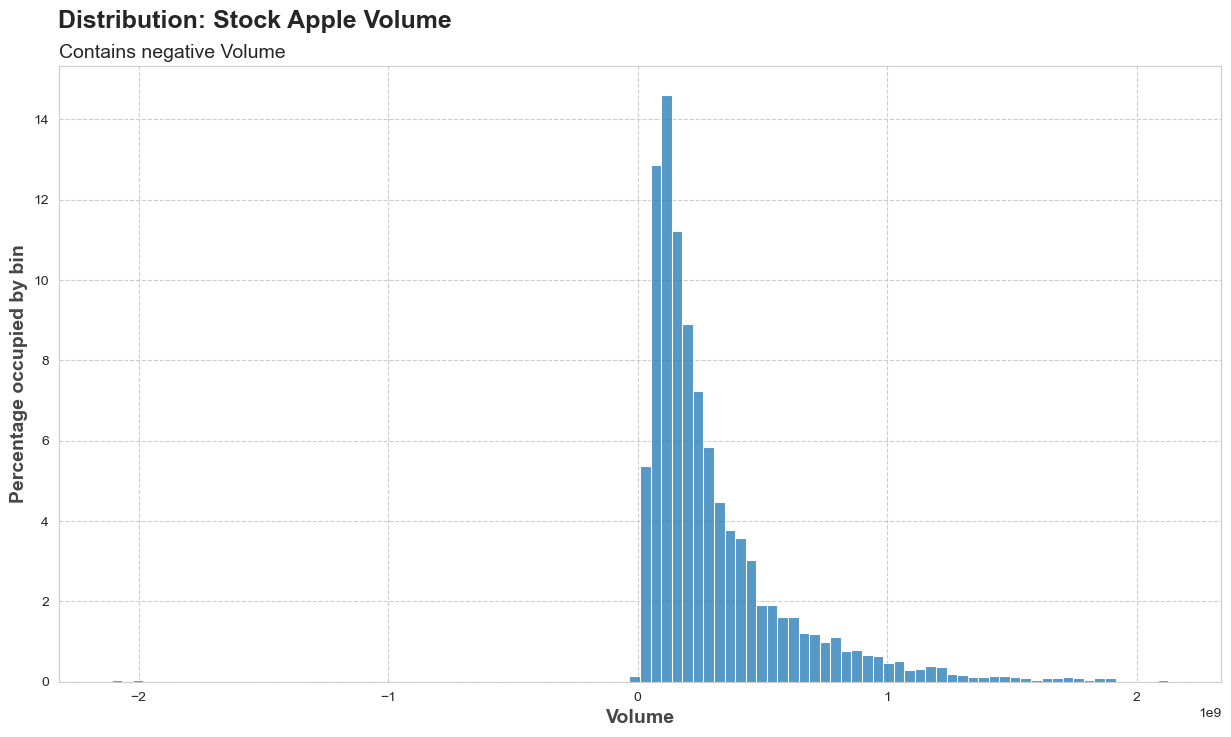

In [16]:
f, ax = plt.subplots()
sns.histplot(df['Volume'], bins=100, stat='percent', ax=ax)

ax.set_xlabel('Volume', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Percentage occupied by bin', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.256, 0.95
f.suptitle(t='Distribution: Stock Apple Volume', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Contains negative Volume', fontsize=14, loc='left')


ax.grid(linestyle='--',)
plt.show()

In [17]:
df[df['Volume'] < 0].head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
690,1983-09-23,0.083365,0.108259,0.111607,0.099330,0.111607,-1462621696,AAPL,-0.253844,-0.028361,-0.156520,0.111576,0.119143
4196,1997-08-06,0.198177,0.234933,0.247768,0.223214,0.225446,-104487296,AAPL,0.332281,0.049427,1.005139,0.129921,0.121971
4197,1997-08-07,0.219831,0.260603,0.263951,0.253348,0.256696,-539528896,AAPL,0.109265,0.021654,1.224231,0.135923,0.123807
4433,1998-07-16,0.282437,0.334821,0.340402,0.319196,0.338170,-1733616896,AAPL,0.088927,0.023065,1.857675,0.228727,0.219529
4496,1998-10-14,0.281496,0.333705,0.368862,0.328683,0.354911,-2014949696,AAPL,-0.035485,-0.010356,1.848151,0.273353,0.281694


I have validated the values in the Adjusted Close columns with negative volumes with true values online and can confirm the values are correct.

#### Exploring Null values and Duplicates

In [18]:
df.isna().sum()

Date                   0
Adj Close              0
Close                  0
High                   0
Low                    0
Open                   0
Volume                 0
stock_name             0
Returns                0
first_diff             0
cumilative_returns     0
20_day_sma             6
50_day_sma            36
dtype: int64

In [19]:
df.dropna(inplace=True)

In [20]:
df.duplicated().sum()

0

In [21]:
df.reset_index(inplace=True, drop=True)

Dataset contains no Null or Duplicate data

#### Extra Cleaning

I could've done additional outlier detection where i remove values 1.5 times the interquatile range but I decided to keep the values as they are. This is because stocks are very volatile and these abnormal returns and price values can happen due to economic events. <br>

Additionally as a safety measure I have compared my timeseries to other sources of truth on the internet and can safely say it looks the same.

---

### Checking the stationarity of Returns and first difference columns

----

returns and first difference are is the percentage change and first difference of the Adj Close columns

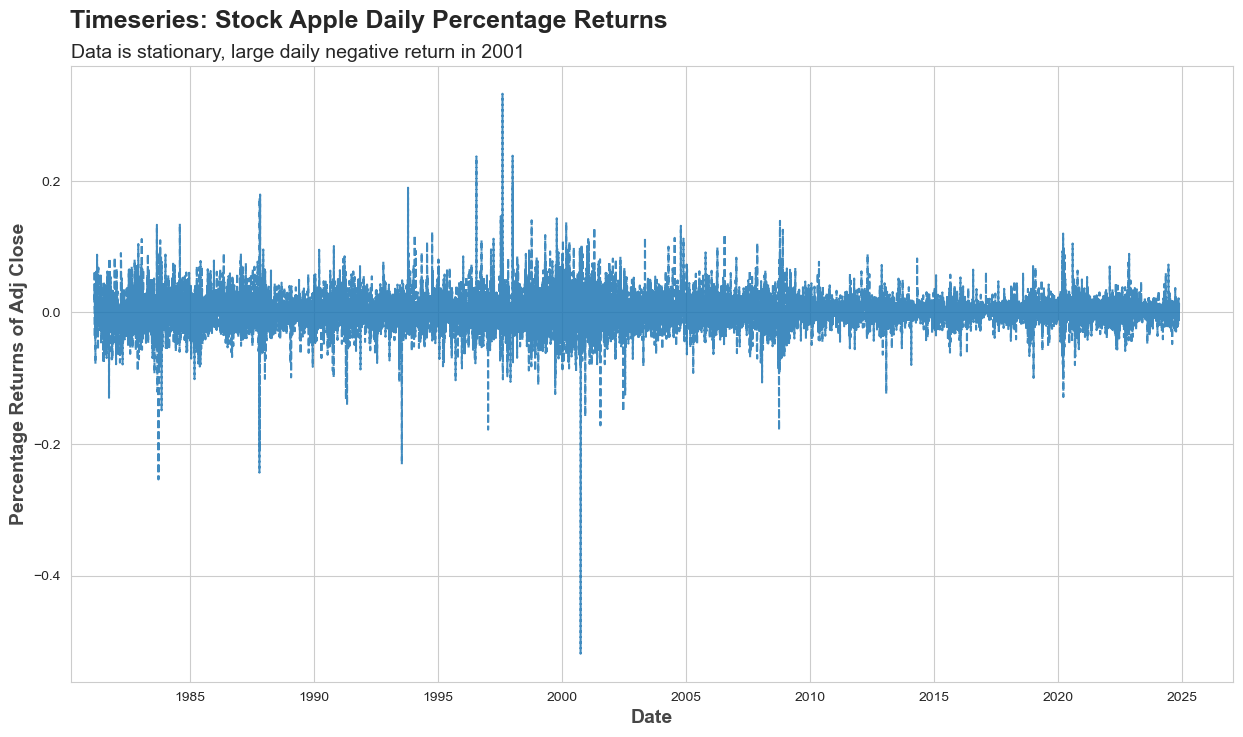

In [22]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='Returns', linestyle='--', markers='o', ax=ax, alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Percentage Returns of Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is stationary, large daily negative return in 2001', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))

plt.show()

Timeseries of returns looks stationary maybe left side has more variance than right

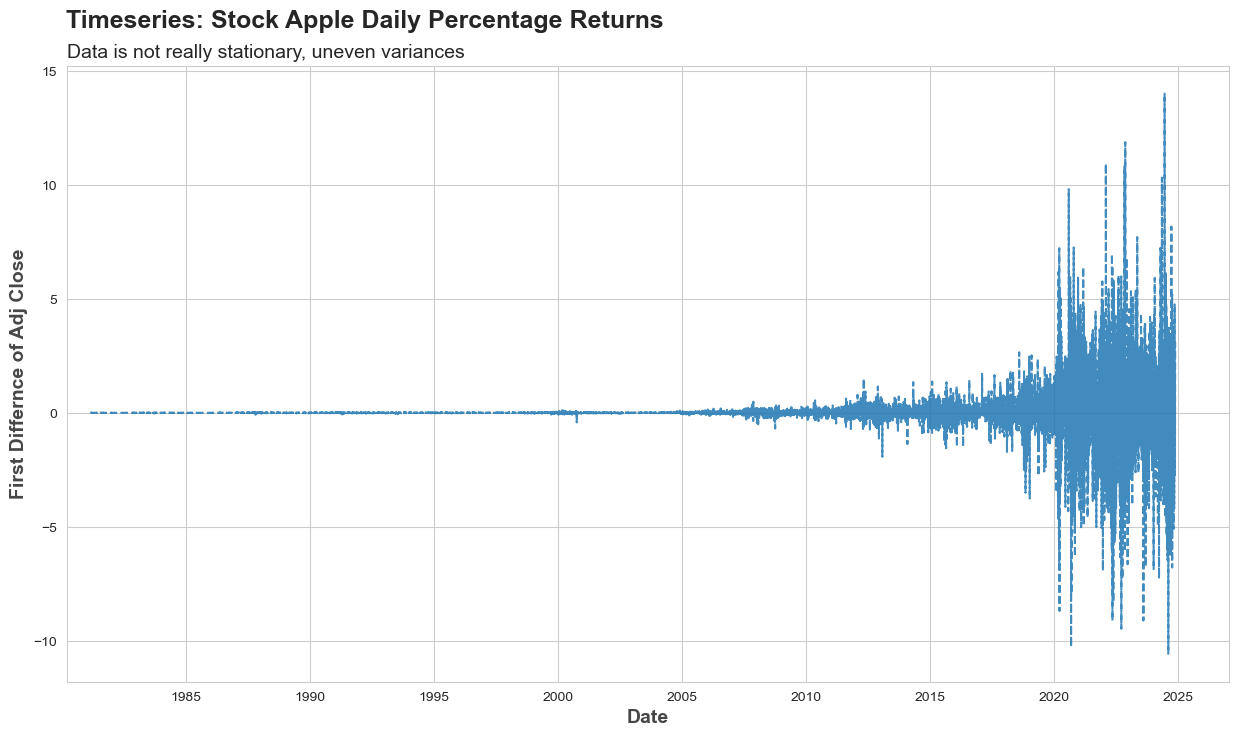

In [23]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='first_diff', linestyle='--', markers='o', alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('First Differnce of Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is not really stationary, uneven variances', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
plt.show()

---

### Further Analysis of Stock data

---

<font size=5 color=orange>Q </font>-- What does the spread of daily, monthly, annual resolution returns look like?

In [24]:
def calculate_period_returns(df: pd.DataFrame) -> dict:
    df['Date'] = pd.to_datetime(df['Date'])
    
    periods = {
        'daily': df.groupby(df['Date'].dt.date)['Adj Close'],
        'weekly': df.groupby(pd.Grouper(key='Date', freq='W'))['Adj Close'],
        'monthly': df.groupby(pd.Grouper(key='Date', freq='M'))['Adj Close'],
        'quarterly': df.groupby(pd.Grouper(key='Date', freq='Q'))['Adj Close'],
        'yearly': df.groupby(pd.Grouper(key='Date', freq='Y'))['Adj Close']
    }
    
    returns_dict = {}
    for period_name, grouped in periods.items():
        period_changes = grouped.agg(['first', 'last']).dropna()
        returns = (period_changes['last'] - period_changes['first']) / period_changes['first'] * 100
        returns_dict[period_name] = returns

    return returns_dict

In [25]:
returns_dict = calculate_period_returns(df)

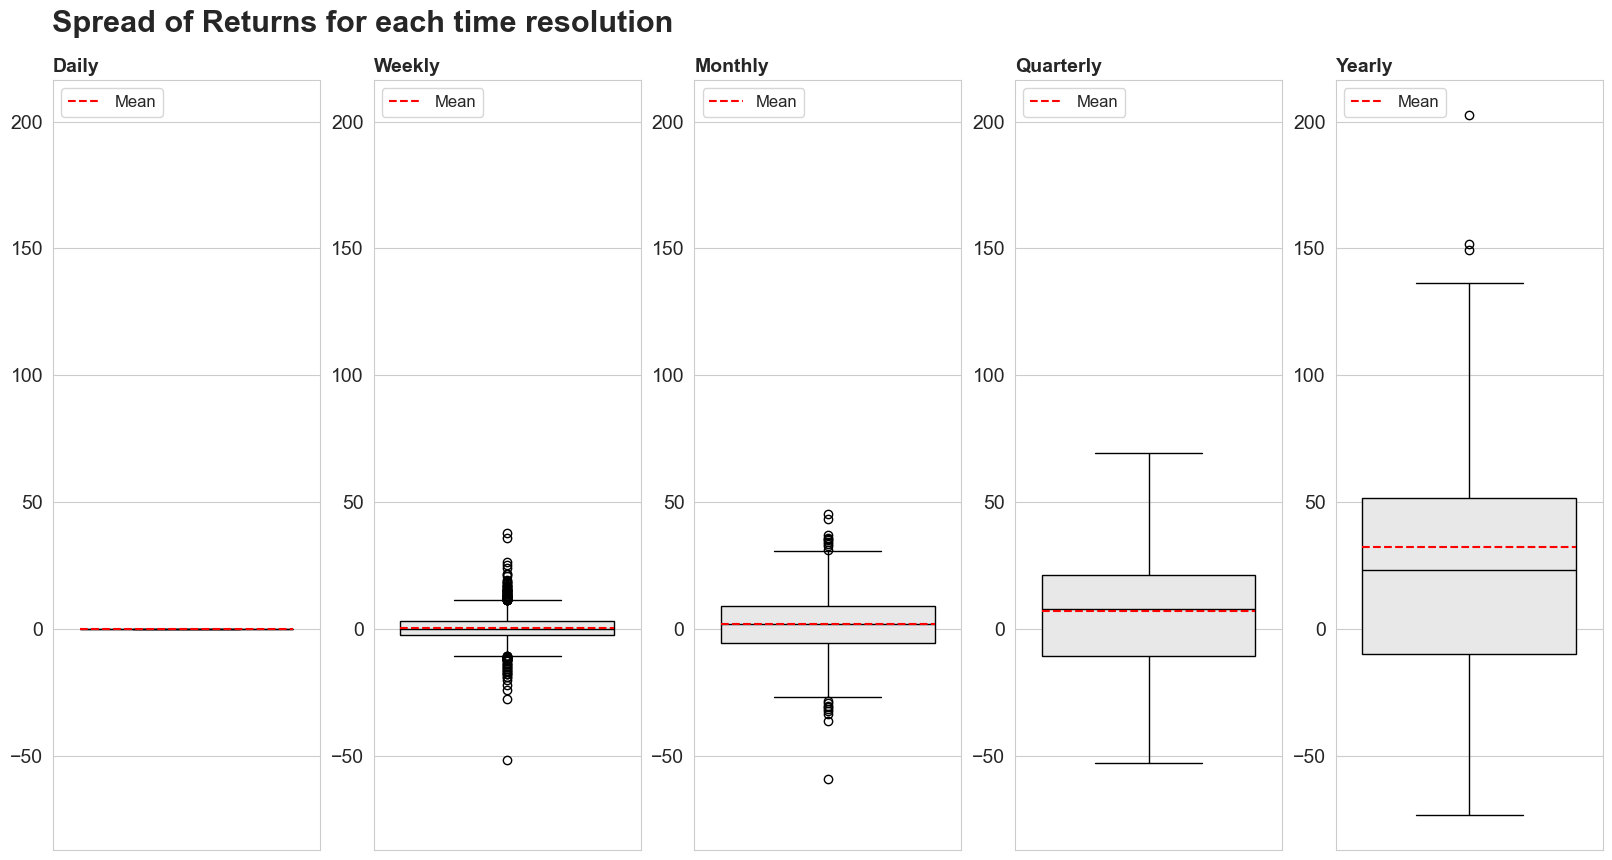

In [63]:
f, ax = plt.subplots(ncols=5, figsize=(20, 10), sharey=True)

for i, (k, v) in enumerate(returns_dict.items()):
    sns.boxplot(data=v, ax=ax[i], meanline=True, showmeans=True, meanprops={'color': 'red', 'lw': 1.5, 'label': 'Mean'}, color='#e8e8e8', linecolor='black')
    ax[i].set_title(k.capitalize(), fontweight='bold', fontsize=14, loc='left')
    ax[i].legend(fontsize=12, loc=2)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    
dx, dy = 0.28, 0.95
f.suptitle(t='Spread of Returns for each time resolution', fontsize=22, x=dx, y=dy, fontweight='bold')
plt.show()


<font size=5 color=orange>Q </font>-- What does the overall correlation look like?

<Axes: >

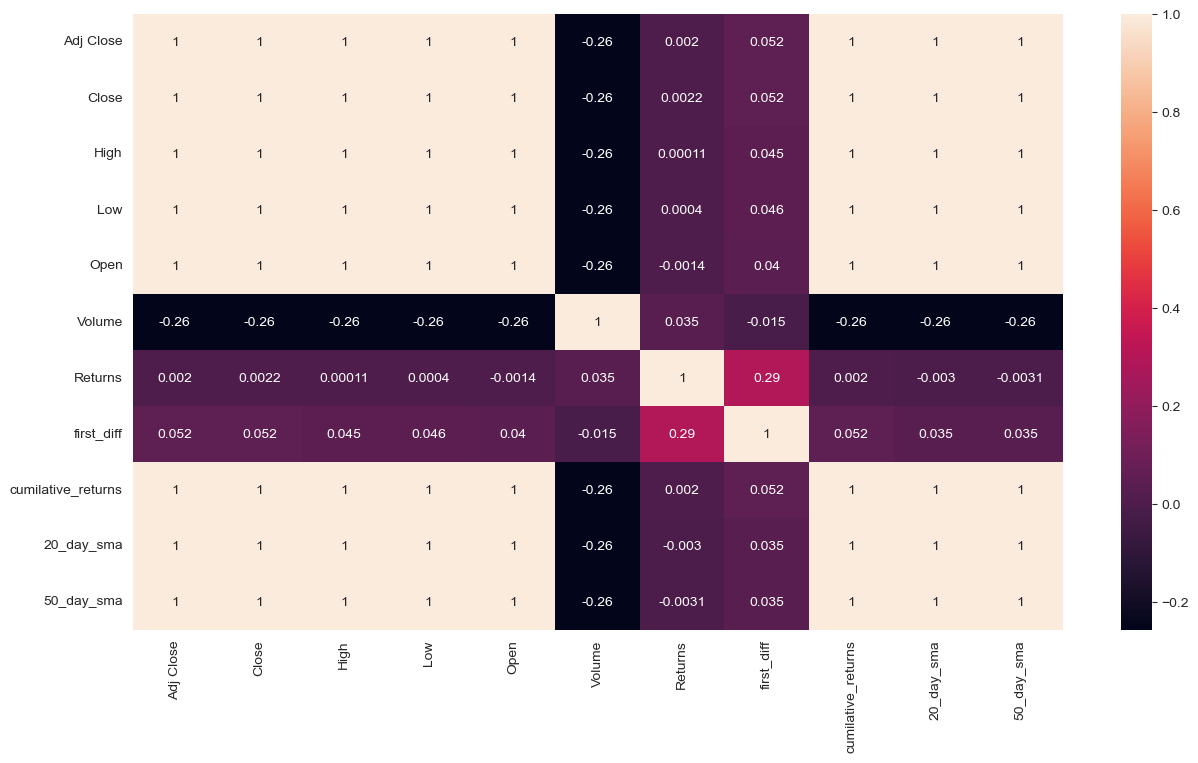

In [66]:
f, ax = plt.subplots()

sns.heatmap(df.corr(numeric_only=True), annot=True)

Most correlated as most of the columns are dependent on each other.

---

### Augmented Dickey Fuller Test

---

In order to use an ARIMA model our data should be stationaly therefore having an normal distribution around the mean and should have no significant changes in the volatility or fluctuations of the data over different time periods. <br>

Therefore we run the Adfuller test, which is a statistical test for stationarity. It works by testing the null hypothesis on a sample that the timeseries in not stationary. Returning test statistics and p-value and Critical values.

In [67]:
from statsmodels.tsa.stattools import adfuller

In [68]:
# First Difference adj close results in really small p_value 3.5*10-30
results = adfuller(df['Returns'], autolag='AIC')
results

(-30.004927912486266,
 0.0,
 11,
 11013,
 {'1%': -3.4309439185375097,
  '5%': -2.8618024793230608,
  '10%': -2.566909712618015},
 -47616.67158176676)

In [69]:
# pct change adj close results in p-value of 0
results = adfuller(df['first_diff'], autolag='AIC')
results

(-17.697628923167034,
 3.548793088467637e-30,
 39,
 10985,
 {'1%': -3.4309454327484765,
  '5%': -2.8618031484539372,
  '10%': -2.5669100687949324},
 29132.061437787357)

The first item in both tuples are the test statistics which is then used to generate the second value in the tuple the p value <font color=red> If the p value > 0.05 we reject the null hypothesis that the graph is stationary</font> and apply another transform.<br>

Finally the last 3 values contain the test statistic for the critical values, our test statistic ended up bieng a lot lower than these so we can reject the null hypothesis

---

### Plotting ACF and PACF

---

Plotting the ACF and PACF is a good way to identify the correct model order. The Autocorrelation function is the correlation between the time series and an ofset n. So written like this, $\text{corr}(y_t, y_{t-n})$. <br>

The PACF or partial autocorrelation is the correlation between a time series and the lagged version of itself after we take away the effort of the correlation at smaller lags. Which means it is just the correlation associated with that particular lag.

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Plot ACF and PACF graphs

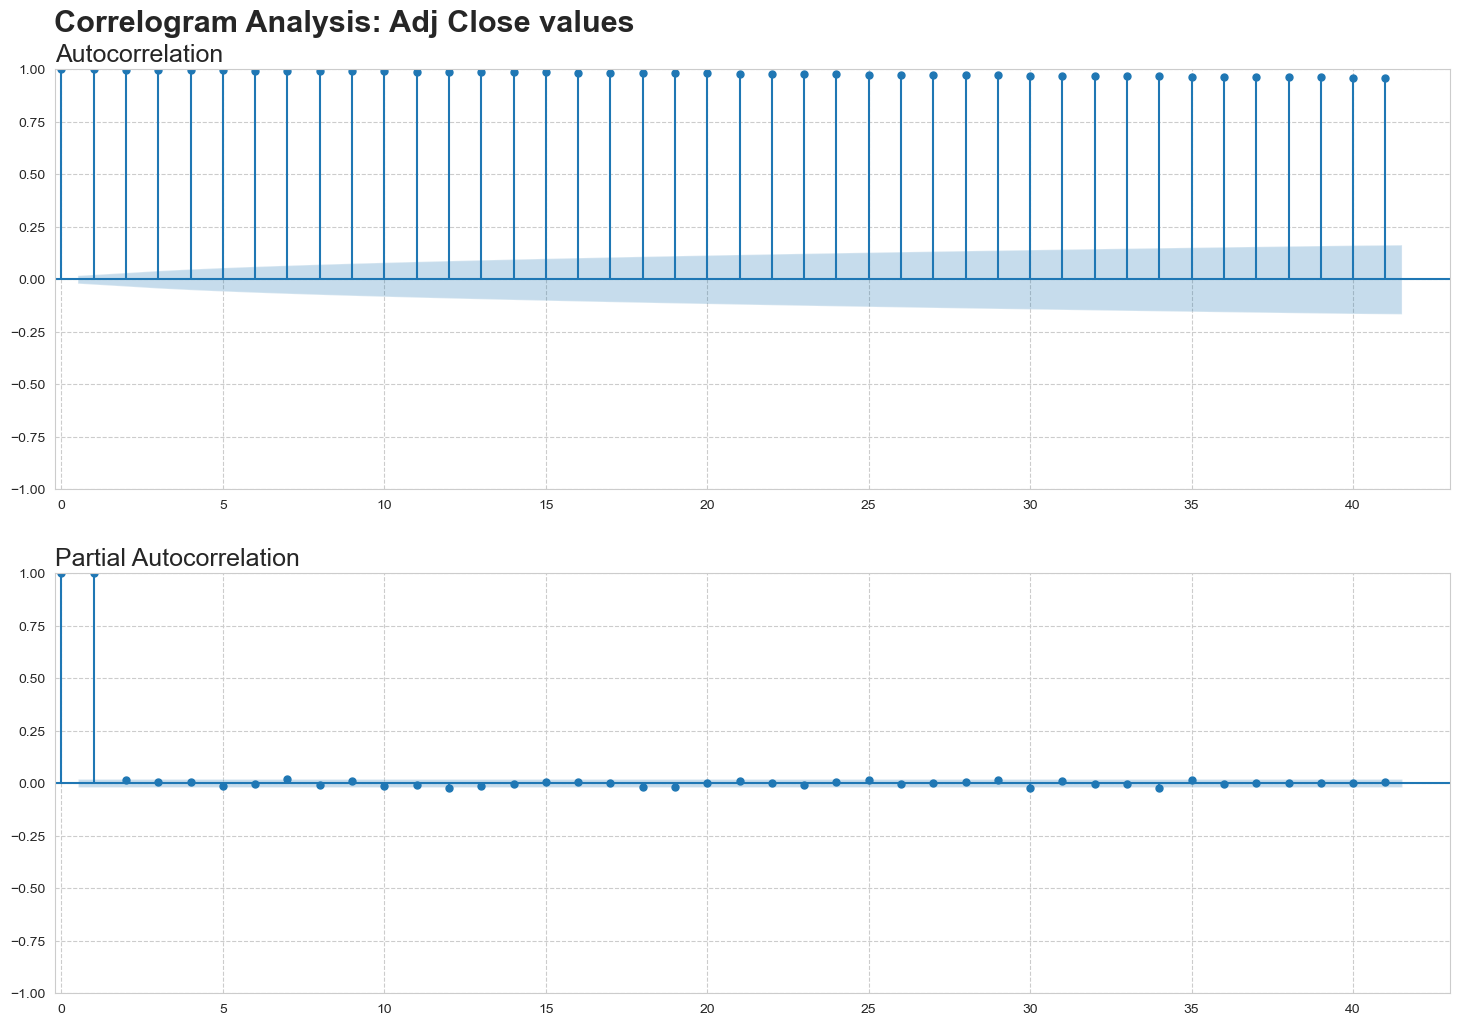

In [71]:
f, ax = plt.subplots(2, 1, figsize=(18, 12))

plot_acf(df['Adj Close'], ax=ax[0], title='')
plot_pacf(df['Adj Close'], ax=ax[1], title='')

dx, dy = 0.2855, 0.93
f.suptitle(t='Correlogram Analysis: Adj Close values', fontsize=22, fontweight='bold', x=dx, y=dy)

ax[0].set_title('Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
ax[1].set_title('Partial Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
for axes in ax:
    axes.set_xlim(-0.2, 43)#
    axes.grid(linestyle='--')
plt.show()

The PACF, effect a number of periods ago to now??

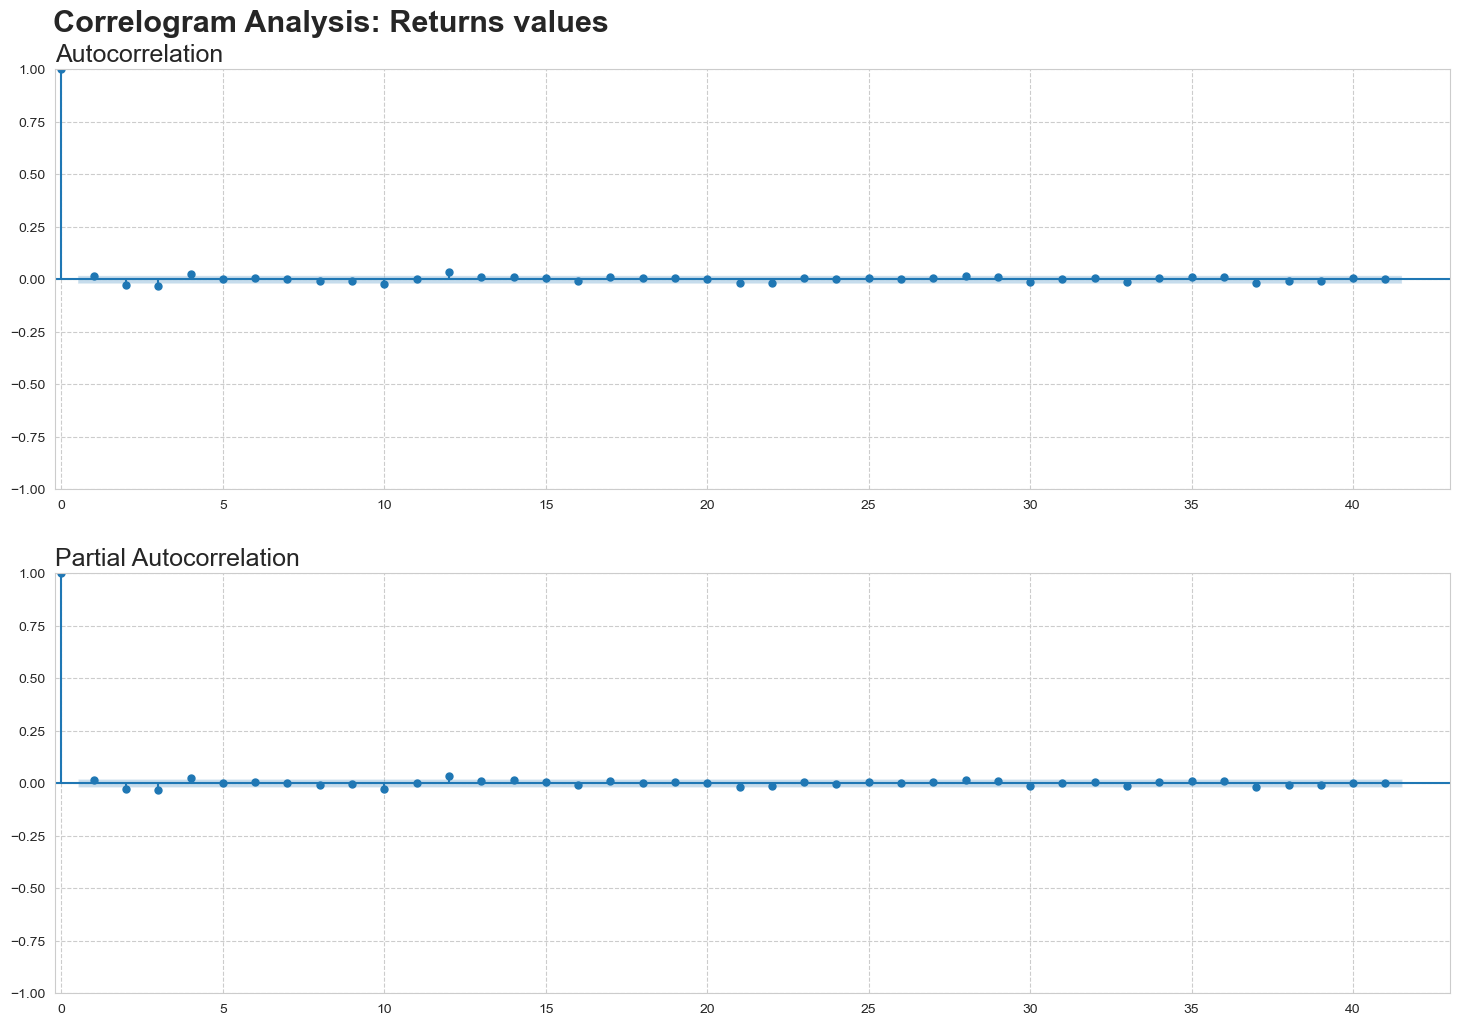

In [72]:
f, ax = plt.subplots(2, 1, figsize=(18, 12))

plot_acf(df['Returns'], ax=ax[0], title='')
plot_pacf(df['Returns'], ax=ax[1], title='')

dx, dy = 0.2785, 0.93
f.suptitle(t='Correlogram Analysis: Returns values', fontsize=22, fontweight='bold', x=dx, y=dy)

ax[0].set_title('Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
ax[1].set_title('Partial Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
for axes in ax:
    axes.set_xlim(-0.2, 43)#
    axes.grid(linestyle='--')
plt.show()

---

### ARIMA Modelling

---

The ARIMA model works by combining the AR and the MA models together. With I or intergrated part bieng the level of differencing done on the data. <br>

An $\text{AR}(p)$ model works by regressing the values of the time series against previous $\text(p)$ values of the same timeseries. So an $\text{AR}(p)$ model works like this below: <br>

$y_t = a_1y_{t-1} + a_2y_{t-2} + ... + a_py_{t-p} + \epsilon_t$ <br>

In a $\text{MA}(q)$ model we regress the values if the timeseries against the previous shock term values of the series. So an $\text{MA}(q)$ model works like this before.

$y_t = m_1\epsilon_{t-1} + m_2\epsilon_{t-2} + ... + m_q\epsilon_{t-q} + \epsilon_t$ <br>

And an $\text{ARMA}(p, q)$ model is just these two models added together so: <br>

$y_t = a_py_{t-p}+ m_q\epsilon_{t-q} + \epsilon_t$

In [73]:
from statsmodels.tsa.arima.model import ARIMA

#### Testing with one order of differencing

In [74]:
model_input = df.set_index('Date')['Adj Close']

In [75]:
p, d, q = 1, 1, 1

model = ARIMA(model_input, order=(p,d,q))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                11025
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14692.377
Date:                Sat, 30 Nov 2024   AIC                          29390.754
Time:                        17:16:18   BIC                          29412.677
Sample:                             0   HQIC                         29398.139
                              - 11025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5848      0.069      8.435      0.000       0.449       0.721
ma.L1         -0.6068      0.068     -8.886      0.000      -0.741      -0.473
sigma2         0.8417      0.003    324.936      0.0

Figure(1500x800)


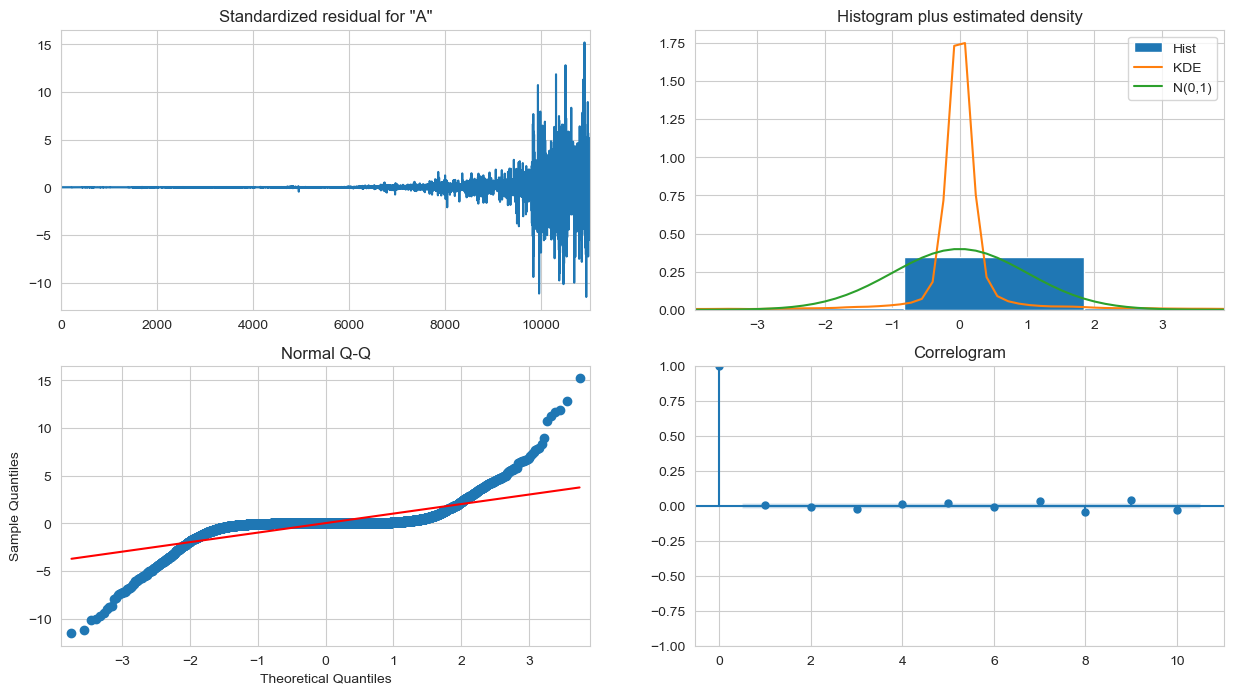

In [76]:
print(results.plot_diagnostics())

Standardized Residuals: Shows increasing volatility over time, with residuals expanding significantly in later periods (observations 8000-11000). <br>

Histogram: Shows a very peaked distribution (highly leptokurtic) with the KDE (orange line) much higher and narrower than the normal distribution (green line). <br>

Q-Q Plot: Shows significant deviation from normality, especially in the upper tail where points curve sharply upward. <br>

Correlogram: Shows good independence of residuals with no significant autocorrelation. <br>


#### Testing model of transformed stationary data no order of differencing

In [77]:
model_input = df.set_index('Date')['Returns']
model_input.head(2)

Date
1981-02-24   -0.035531
1981-02-25    0.063154
Name: Returns, dtype: float32

In [78]:
p, q = 1, 1

model = ARIMA(model_input, order=(p,0,q))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                11025
Model:                 ARIMA(1, 0, 1)   Log Likelihood               23870.528
Date:                Sat, 30 Nov 2024   AIC                         -47733.057
Time:                        17:16:22   BIC                         -47703.825
Sample:                             0   HQIC                        -47723.210
                              - 11025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      4.160      0.000       0.001       0.002
ar.L1          0.5004      1.398      0.358      0.720      -2.240       3.241
ma.L1         -0.5032      1.396     -0.361      0.7

Figure(1500x800)


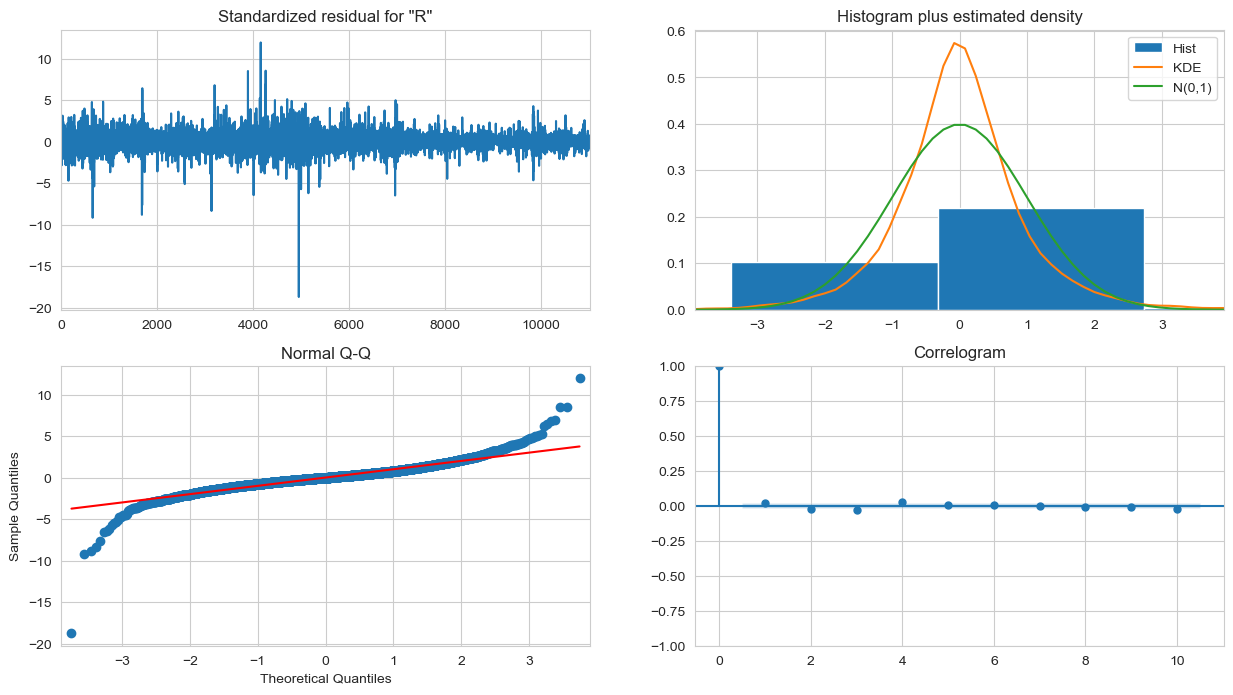

In [79]:
print(results.plot_diagnostics())

Standardized Residual Plot <br>
The plot shows residuals fluctuating mostly between -5 and +5, with one notable outlier around observation 5000 reaching -20.<br> The pattern suggests relatively consistent volatility over time, though there are clusters of higher volatility periods.<br>

Histogram plus Estimated Density (Top Right)<br>
The histogram shows the distribution of residuals with an overlaid kernel density estimate (orange line) and normal distribution (green line).<br> The distribution appears slightly leptokurtic (more peaked than normal) and shows some right skewness. The residuals are concentrated around zero but have heavier tails than a normal distribution would predict.<br>

Normal Q-Q Plot (Bottom Left) <br>
This quantile-quantile plot compares the residuals against theoretical normal quantiles. The blue points <br> follow the red reference line reasonably well in the middle but deviate at the tails, particularly below -3 and above +3 standard deviations. The extreme outlier at -20 is clearly visible at the bottom left.<br>

Correlogram (Bottom Right)<br>
The autocorrelation function plot shows very low correlation values across all lags except for lag 0 (which is always 1.0). All other lags show correlations very close to zero, indicating that the residuals are effectively uncorrelated with their past values, which is a desirable property for a well-fitted model.

Therefore we this model where we take Returns as the stationary value

#### Forecasting and getting prediction of values

In [80]:
forecast = results.get_prediction(start='2001-05-01', end='2014-05-01')
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [81]:
prediction_slice = model_input['2001-05-01':'2014-05-01']

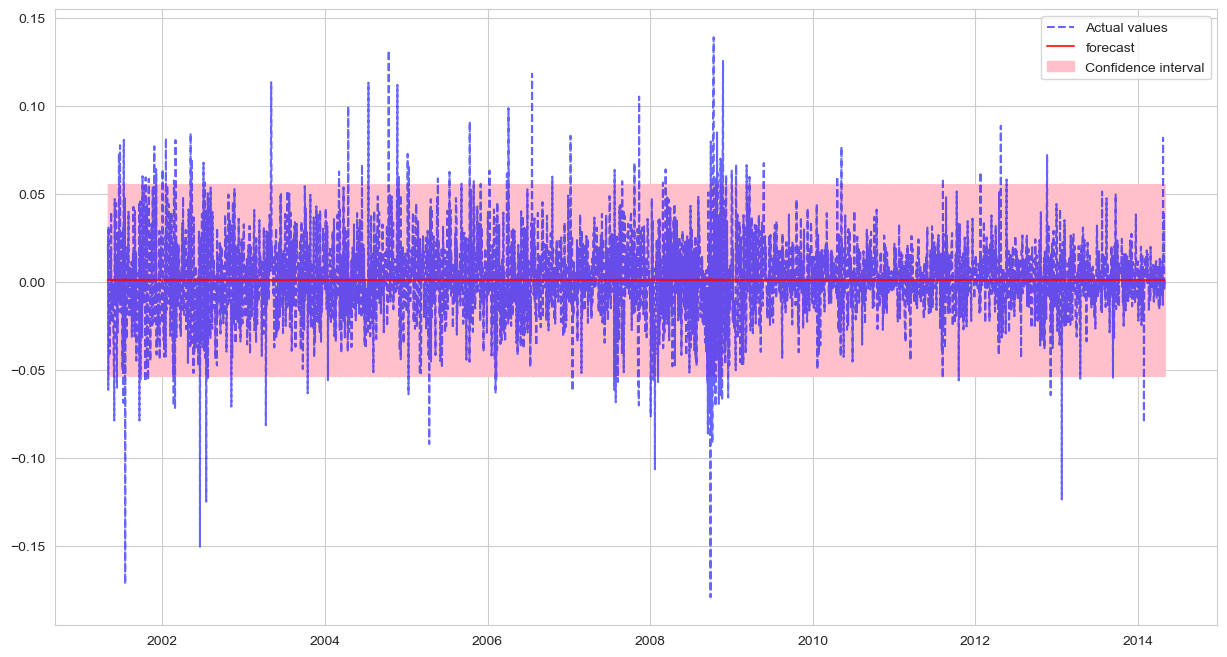

In [82]:
plt.figure()

plt.plot(prediction_slice, color='blue', linestyle='--', alpha=0.6, label='Actual values')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast', alpha=0.8)
plt.fill_between(mean_forecast.index, confidence_intervals['lower Returns'], confidence_intervals['upper Returns'], color='pink', label='Confidence interval',)
plt.legend()
plt.show()

In [83]:
model_input

Date
1981-02-24   -0.035531
1981-02-25    0.063154
1981-02-26    0.014850
1981-02-27    0.034153
1981-03-02    0.004717
                ...   
2024-11-08   -0.001188
2024-11-11   -0.012029
2024-11-12    0.000000
2024-11-13    0.003969
2024-11-14    0.013770
Name: Returns, Length: 11025, dtype: float32

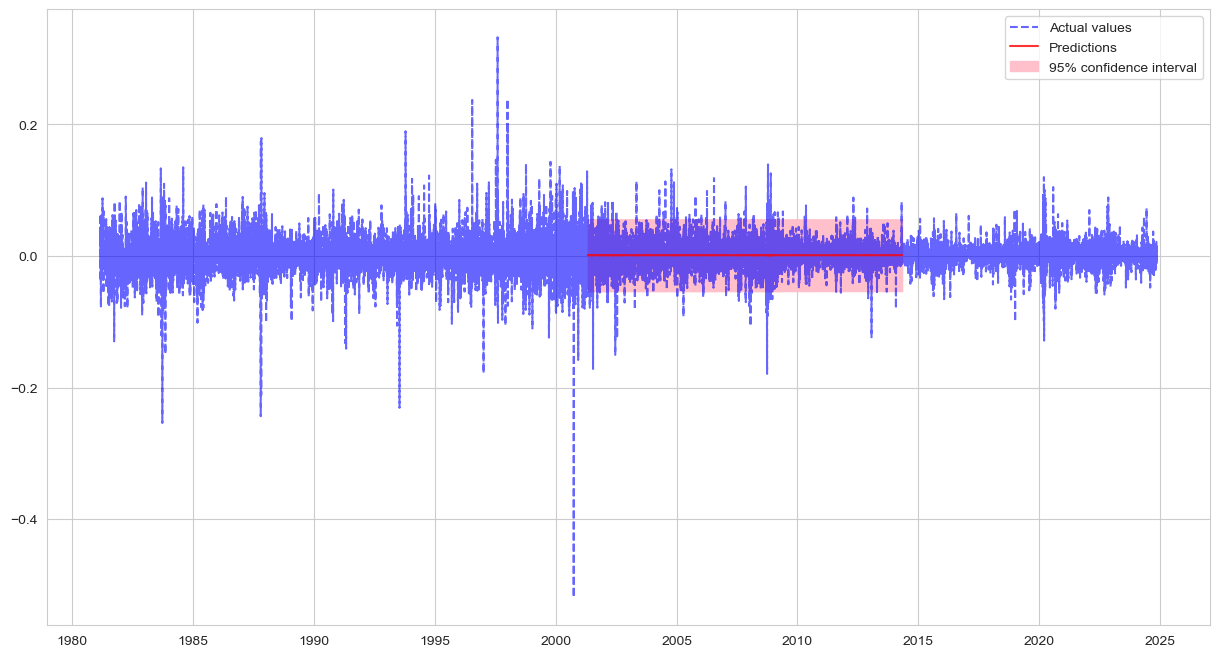

In [84]:
plt.figure()

plt.plot(model_input, color='blue', linestyle='--', alpha=0.6, label='Actual values')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='Predictions', alpha=0.8)
plt.fill_between(mean_forecast.index, confidence_intervals['lower Returns'], confidence_intervals['upper Returns'], color='pink', label='95% confidence interval',)
plt.legend()
plt.show()

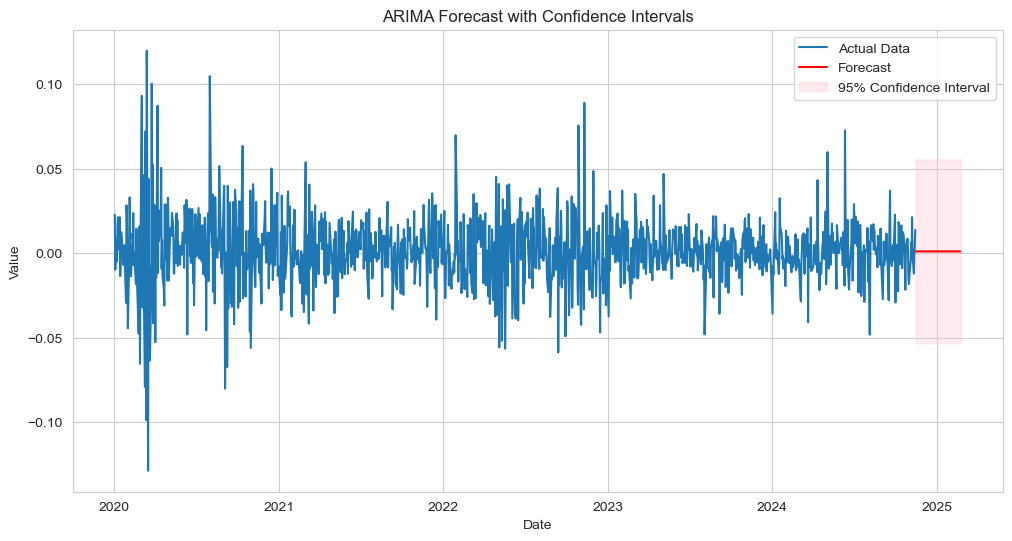

In [85]:
# Get forecast results
forecast_results = results.get_forecast(steps=100, alpha=0.05)

# Extract forecasts and confidence intervals
mean_forecast = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

# Create forecast dates
forecast_dates = pd.date_range(start=model_input.index[-1], periods=101)[1:]

# Plot results
plt.figure(figsize=(12, 6))
from_year_2020 = model_input['2020-01-01':]
plt.plot(from_year_2020.index, from_year_2020, label='Actual Data')
plt.plot(forecast_dates, mean_forecast, color='red', label='Forecast')
plt.fill_between(forecast_dates,
                 confidence_intervals.iloc[:, 0],  # Lower bound
                 confidence_intervals.iloc[:, 1],  # Upper bound
                 color='pink', alpha=0.3,
                 label='95% Confidence Interval')

plt.title('ARIMA Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



#### Metrics

In [86]:
print(f"The Mean Absolute Error says on avergage each data point is roughly {round(results.mae, 5)}, away from true Return value")

The Mean Absolute Error says on avergage each data point is roughly 0.01904, away from true Return value


In [87]:
print(f"The RMSE: {round(np.sqrt(results.mse), 5)}, and the MSE: {round(results.mse, 5)}")

The RMSE: 0.02776, and the MSE: 0.00077


In [88]:
results.aic, results.bic

(-47733.05679373329, -47703.825110932026)